In [49]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


### Import Data

In [50]:
import pandas as pd

doganella_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/Aquifer_Doganella.csv')
doganella_df.head()

,Date,Rainfall_Monteporzio,Rainfall_Velletri,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_2,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Depth_to_Groundwater_Pozzo_5,Depth_to_Groundwater_Pozzo_6,Depth_to_Groundwater_Pozzo_7,...,Volume_Pozzo_1,Volume_Pozzo_2,Volume_Pozzo_3,Volume_Pozzo_4,Volume_Pozzo_5+6,Volume_Pozzo_7,Volume_Pozzo_8,Volume_Pozzo_9,Temperature_Monteporzio,Temperature_Velletri
0,01/01/2004,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.30,8.60
1,02/01/2004,0.2,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.70,6.25
2,03/01/2004,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.40,9.80
3,04/01/2004,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.35,5.95
4,05/01/2004,0.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.60,5.85


In [51]:
doganella_df.isnull().sum()
doganella_df = doganella_df.dropna()
print(doganella_df)

            Date  Rainfall_Monteporzio  Rainfall_Velletri  \
5486  08/01/2019                   4.4                3.6   
5487  09/01/2019                   2.0               11.2   
5488  10/01/2019                   0.0                0.0   
5489  11/01/2019                   0.0                0.0   
5490  12/01/2019                   0.0                0.0   
...          ...                   ...                ...   
6021  26/06/2020                   0.0                0.0   
6022  27/06/2020                   0.0                0.0   
6023  28/06/2020                   0.0                0.0   
6024  29/06/2020                   0.0                0.0   
6025  30/06/2020                   0.0                0.0   

      Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
5486                        -36.88                        -99.99   
5487                        -37.65                        -99.99   
5488                        -37.65                       -100.6

### Format Time Series Date Field

In [52]:
from datetime import datetime

original_date = doganella_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
doganella_df['formatted_date'] = pd.to_datetime(doganella_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(doganella_df['formatted_date'])


5486    01/08/2019
5487    01/09/2019
5488    01/10/2019
5489    01/11/2019
5490    01/12/2019
           ...    
6021    06/26/2020
6022    06/27/2020
6023    06/28/2020
6024    06/29/2020
6025    06/30/2020
Name: formatted_date, Length: 186, dtype: object


In [53]:
doganella_df = doganella_df.set_index('formatted_date')
doganella_df = doganella_df.drop(columns=['Date'])
doganella_df.head()

,Rainfall_Monteporzio,Rainfall_Velletri,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_2,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Depth_to_Groundwater_Pozzo_5,Depth_to_Groundwater_Pozzo_6,Depth_to_Groundwater_Pozzo_7,Depth_to_Groundwater_Pozzo_8,...,Volume_Pozzo_1,Volume_Pozzo_2,Volume_Pozzo_3,Volume_Pozzo_4,Volume_Pozzo_5+6,Volume_Pozzo_7,Volume_Pozzo_8,Volume_Pozzo_9,Temperature_Monteporzio,Temperature_Velletri
formatted_date,,,,,,,,,,,,,,,,,,,,,
01/08/2019,4.4,3.6,-36.88,-99.99,-114.80,-101.44,-103.73,-93.55,-93.40,-99.09,...,1875.89,3535.38,2664.94,3578.22,7741.62,2621.59,3829.03,2703.82,4.66,5.93
01/09/2019,2.0,11.2,-37.65,-99.99,-114.80,-101.36,-104.12,-93.56,-93.90,-99.07,...,2021.33,3528.29,2701.80,3572.89,7700.90,2610.22,3797.06,2498.40,3.47,5.65
01/10/2019,0.0,0.0,-37.65,-100.60,-114.80,-101.13,-104.18,-93.62,-97.43,-99.02,...,2064.89,3528.50,3534.34,3514.50,6695.28,2612.81,3028.82,3399.59,1.30,4.84
01/11/2019,0.0,0.0,-37.65,-100.60,-114.88,-101.13,-104.18,-93.62,-97.43,-99.02,...,1998.29,3531.24,3546.43,3580.24,7799.18,2615.18,3807.11,1995.30,0.61,3.87
01/12/2019,0.0,0.0,-37.65,-100.60,-114.89,-101.13,-104.18,-93.62,-97.43,-99.02,...,1848.10,3533.22,2926.19,3578.00,7743.85,2617.96,3811.82,3438.83,1.22,3.34


In [54]:
doganella_df.columns

Index(['Rainfall_Monteporzio', 'Rainfall_Velletri',
       'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_2',
       'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4',
       'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6',
       'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8',
       'Depth_to_Groundwater_Pozzo_9', 'Volume_Pozzo_1', 'Volume_Pozzo_2',
       'Volume_Pozzo_3', 'Volume_Pozzo_4', 'Volume_Pozzo_5+6',
       'Volume_Pozzo_7', 'Volume_Pozzo_8', 'Volume_Pozzo_9',
       'Temperature_Monteporzio', 'Temperature_Velletri'],
      dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [55]:
target_columns = doganella_df[['Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_2', 
                               'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 
                               'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9']].columns.tolist()
feature_columns = doganella_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [56]:
# Ensure X is defined

def prepare_multi_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_multi_feature_data(doganella_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("doganella_df shape:", doganella_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [57]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 124, Test size: 32


### LSTM Model Multi-Target

In [58]:
# from tensorflow.keras.layers import Bidirectional

# n_features = len(feature_columns)

# model = Sequential([
#     # Increase capacity for better pattern recognition
#     Bidirectional(LSTM(128, return_sequences=True, input_shape=(30, n_features))),
#     Dropout(0.2),
    
#     Bidirectional(LSTM(64, return_sequences=True)),
#     Dropout(0.2),
    
#     Bidirectional(LSTM(32)),
#     Dropout(0.2),
    
#     # Bidirectional(LSTM(16)),
#     # Dropout(0.2),
    
#     Dense(32, activation='relu'),
#     Dense(9)
# ])

# # Use Huber loss to handle outliers better
# model.compile(optimizer=Adam(learning_rate=0.01), loss='huber')

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Dense, Dropout, LayerNormalization, Attention
from tensorflow.keras.optimizers import Adam

n_features = len(feature_columns)

model = Sequential([
    # Initial high-capacity LSTM layer with more units
    Bidirectional(LSTM(256, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.2),
    LayerNormalization(),

    # Second LSTM layer with fewer units, but still high capacity
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    LayerNormalization(),

    # Adding a GRU layer for variety
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.2),
    LayerNormalization(),

    # Attention layer to focus on important time steps
    Attention(),

    # Final LSTM layer with fewer units
    Bidirectional(LSTM(32)),
    Dropout(0.2),

    # Dense layers for added complexity
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(9)  # Output layer
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, Dropout, LayerNormalization, Attention

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Reshape to 3D
#WX_train = X_train.reshape((X_train.shape[0], 30, len(feature_columns)))
n_features = len(feature_columns)

# Define the input layer
inputs = Input(shape=(30, n_features))

# Initial high-capacity LSTM layer with more units
x = Bidirectional(LSTM(256, return_sequences=True))(inputs)
x = Dropout(0.2)(x)
x = LayerNormalization()(x)

# Second LSTM layer with fewer units, but still high capacity
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = LayerNormalization()(x)

# Adding a GRU layer for variety
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = LayerNormalization()(x)

# Attention layer to focus on important time steps
attention = Attention()([x, x])

# Final LSTM layer with fewer units
x = Bidirectional(LSTM(32))(attention)
x = Dropout(0.2)(x)

# Dense layers for added complexity
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(9)(x)  # Output layer

# Create the model
model = Model(inputs, outputs)

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')


### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [61]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x708f2a3d3740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[ 0.23905325 -0.08593622 -0.21771918 -0.13831656 -0.0418947  -0.42288178
   0.15919124 -0.04987827 -0.3245846 ]
 [ 0.24067412 -0.08644333 -0.22651881 -0.13770011 

### Convert back to normal scale

In [62]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 778ms/step - loss: 0.1397 - val_loss: 0.0606
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - loss: 0.0565 - val_loss: 0.0368
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - loss: 0.0395 - val_loss: 0.0321
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - loss: 0.0373 - val_loss: 0.0327
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - loss: 0.0299 - val_loss: 0.0370
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - loss: 0.0244 - val_loss: 0.0343
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.0228 - val_loss: 0.0329
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - loss: 0.0215 - val_loss: 0.0351
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - loss: 0.0194 - val_loss: 0.0377
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - loss: 0.0203 - val_loss: 0.0384
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - loss: 0.0207 - val_loss: 0.0361
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - loss: 0.0188 - val_l

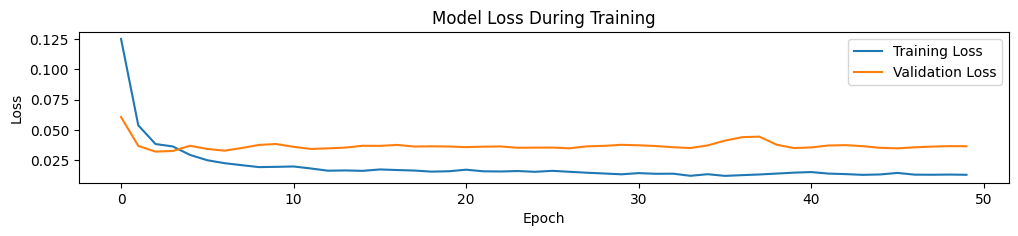

In [63]:
import matplotlib.pyplot as plt

# Fit the model and store the history
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [64]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

### Evaluate 3 Targets

In [65]:
evaluate_regression_lstm(y_test_orig[0], test_pred[0])


Regression Metrics:
R² Score: -163405.9853
MAE: 97.3930
RMSE: 99.0466


(-163405.98525810975, 97.39300831407873, 99.04664572923417)

In [66]:
evaluate_regression_lstm(y_test_orig[1], test_pred[1])


Regression Metrics:
R² Score: -163341.3106
MAE: 97.4033
RMSE: 99.0621


(-163341.31057683143, 97.4032673104944, 99.06205337674893)

In [67]:
evaluate_regression_lstm(y_test_orig[2], test_pred[2])


Regression Metrics:
R² Score: -162510.0842
MAE: 97.4186
RMSE: 99.0771


(-162510.08420969005, 97.41862766725819, 99.07707890569439)

## Find Optimal Learning Rate 

In [68]:
# def find_optimal_lr(model, X_train, y_train):
#     lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
#     losses = []
    
#     for lr in lr_schedule:
#         model.optimizer.learning_rate.assign(lr)
#         loss = model.train_on_batch(X_train[:32], y_train[:32])
#         losses.append(loss)
        
#     best_lr = lr_schedule[np.argmin(losses)]
#     return best_lr

# find_optimal_lr(model, X_train, y_train)

## Plot Residuals - Actual vs Predicted

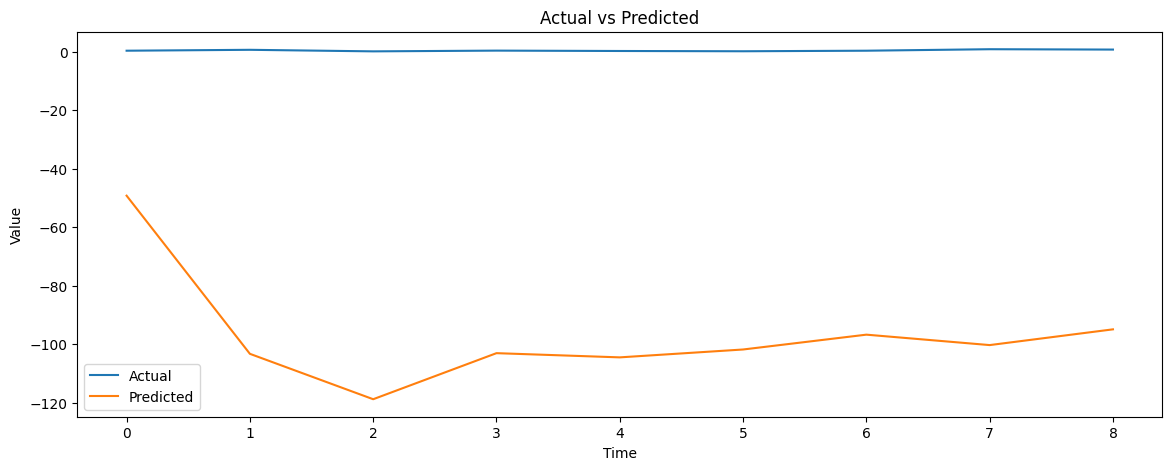

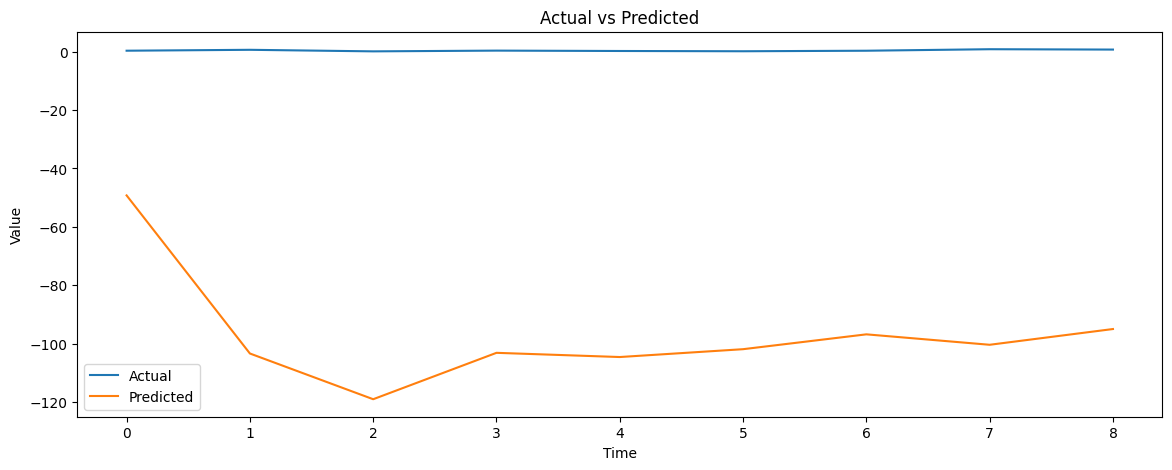

In [69]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test[0], test_pred[0])
plot_actual_vs_predicted(y_test[1], test_pred[1])

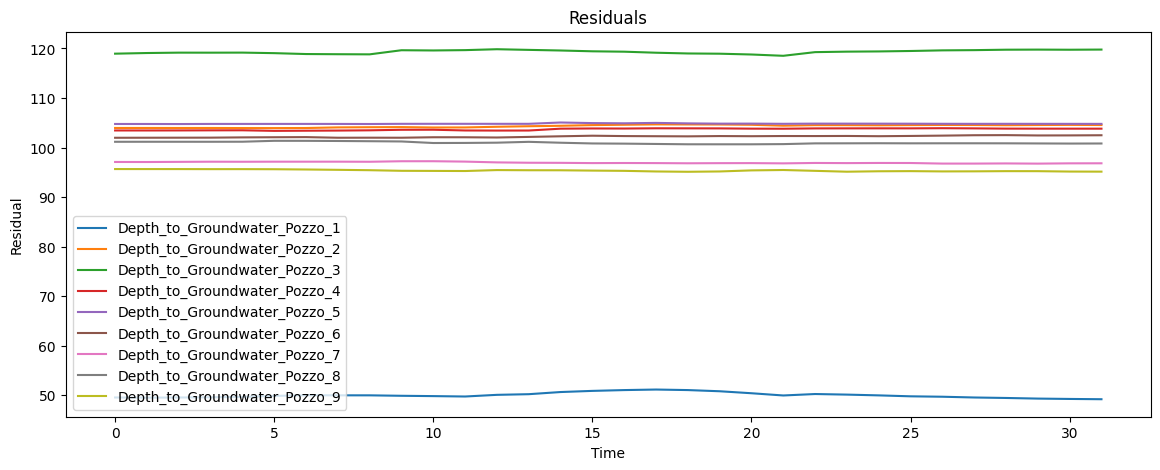

In [70]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label=target_columns)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')